### Load Libraries

In [1]:
# Load dependencies
import pandas as pd
import numpy as np
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Read the txt with total users file

In [2]:
# Read all users
df_all_users = pd.read_csv('data/install_log.csv', names=['nickname', 'DateStart','GamificationStart'])
# Keep only the last installation to drop duplicate or truplicates
df_all_users = df_all_users.drop_duplicates(subset='nickname', keep='last')
df_all_users

,nickname,DateStart,GamificationStart
1,TheArk,2017-04-11,0
2,Federico,2017-04-11,1
3,evakuruczleki,2017-04-11,0
4,Shan,2017-04-11,1
5,Giada,2017-04-11,0
7,myrto,2017-04-11,0
8,ARDecre,2017-04-11,1
10,Shani,2017-04-11,1
11,MarioStefano,2017-04-11,0
12,Ricky,2017-04-12,1


### Read the JSON files from directory

In [3]:
# Read the directory with the data and save file_names in a list
path_to_json_files = 'data/'
json_files = [single_json for single_json in os.listdir(path_to_json_files) if single_json.endswith('.json')]

In [4]:
json_files

['Phrasebook_Dump_aggelos_NOGamification_2017_04_25.json',
 'Phrasebook_Dump_ARDecre_NOGamification_2017_05_01.json',
 'Phrasebook_Dump_ARDecre_YESGamification_2017_04_23.json',
 'Phrasebook_Dump_benni_YESGamification_2017_05_01.json',
 'Phrasebook_Dump_Bill Bilalis_NOGamification_2017_04_22.json',
 'Phrasebook_Dump_darthsack _NOGamification_2017_05_02.json',
 'Phrasebook_Dump_FedeCornalba_NOGamification_2017_04_11.json',
 'Phrasebook_Dump_FedeCornalba_YESGamification_2017_05_02.json',
 'Phrasebook_Dump_Federico_YESGamification_2017_04_26.json',
 'Phrasebook_Dump_Giada_NOGamification_2017_04_22.json',
 'Phrasebook_Dump_Giada_YESGamification_2017_05_02.json',
 'Phrasebook_Dump_MarioStefano_NOGamification_2017_04_23.json',
 'Phrasebook_Dump_MarioStefano_YESGamification_2017_05_01.json',
 'Phrasebook_Dump_myrto_NOGamification_2017_04_22.json',
 'Phrasebook_Dump_myrto_YESGamification_2017_05_02.json',
 'Phrasebook_Dump_TheArk_NOGamification_2017_04_21.json',
 'Phrasebook_Dump_TheArk_YESGam

Keep filenames as reference for later feeding

### Usefull functions

In [5]:
# Create a function that gets the date from filename title
def getEndDate(s):
    first_split = s.split('_')[4]
    second_split = s.split('_')[5]
    third_split = s.split('_')[6][:-5]
    return first_split + '-' + second_split + '-' + third_split

In [6]:
# Create a function that gets the YES/NO Gamification from filename title
def getGamification(s):
    first_split = s.split('_')[3]
    return first_split[:-12]

In [7]:
# Create a function that gets the nickname from filename title
def getNickname(s):
    first_split = s.split('_')[2]
    return first_split

In [8]:
# Create a function that gets the date of a datetime string
def getDate(s):
    first_split = s.split(' ')[0]
    return first_split

In [9]:
# Calculate the duration of use in days for each user
def getDuration(created, closed):
    return closed-created

In [10]:
# Create a function that gets the hour of a datetime string
def getHour(s):
    first_split = s.split(' ')[1]
    return int(first_split.split(':')[0])

### Read each file seperately

In [40]:
# Create function per user with nickname and gamification flagger parameter
def loadUserInfo(nick,flagger):
    for filename in json_files:
        if getNickname(filename) == nick and getGamification(filename)== flagger:
            with open('data/'+filename) as json_data:
                d = json.load(json_data)
                temp_challenges_df = pd.DataFrame(columns = ['correct','createdOn','id','phraseId'])

                # Created unlocked badges pandas dataframe
                unlocked_badges = [(badge['badgeName'],badge['createdOn']) for badge in d['badges'] for kk in badge.keys() if kk=='createdOn']
                df_badges = pd.DataFrame(unlocked_badges,columns=['Name', 'Date'])

                # Load phrasebook data into a pandas dataframe
                df_phrasebook = pd.DataFrame(d['phrasebook'])
                df_phrasebook = pd.concat([temp_challenges_df, df_phrasebook])

                # Load challenges data into a pandas dataframe
                df_challenges = pd.DataFrame(d['challenges'])

                # Load user data into a pandas dataframe
                df_user = pd.DataFrame(d['user'])
                df_user.columns = ['GamificationEnd', 'DateEnd', 'foreignLanguage', 'hasSwitchedVersion', 'level', 'motherLanguage', 'nickname', 'totalXP']
                # Merge with the install_log file
                df_user = pd.merge(df_user,df_all_users,on='nickname',how='inner')
                # Now create a new column named year and store the values of the above function
                # Change dateEnd
                df_user['DateEnd']= getEndDate(filename)
                df_user['DateEnd'] = pd.to_datetime(df_user['DateEnd'])
                df_user['DateStart'] = pd.to_datetime(df_user['DateStart'])
                df_user['daysUsed'] = df_user[['DateStart','DateEnd']].apply(lambda x: getDuration(*x), axis=1)
                # Rearrange user dataframe 
                df_user = df_user[['nickname','motherLanguage','foreignLanguage','GamificationStart','GamificationEnd','hasSwitchedVersion', 'DateStart', 'DateEnd', 'daysUsed', 'totalXP', 'level']]
            
            return df_user, df_phrasebook, df_challenges, df_badges

So when we want to reach a user's info, phrasebook, challenges table and badges table we should act adequately:
   * **user info**: loadUserInfo(nickname, flagger)[0]
   * **phrasebook**: loadUserInfo(nickname, flagger)[1]
   * **challenges**: loadUserInfo(nickname, flagger)[2]
   * **badges**: loadUserInfo(nickname, flagger)[3]

### Check data for each user (examples)

In [35]:
# If we want the user info for ARDecre WITH gamification we write 
loadUserInfo('myrto', 'NO')[0]

,nickname,motherLanguage,foreignLanguage,GamificationStart,GamificationEnd,hasSwitchedVersion,DateStart,DateEnd,daysUsed,totalXP,level
0,myrto,GREEK,"DANISH, POLISH",0,0,0,2017-04-11,2017-04-22,11 days,0,0


In [48]:
# If we want the phrasebook of Federico WITH gamification we write
loadUserInfo('myrto', 'NO')[2]

,correct,createdOn,id,phraseId
0,1,2017-04-22 01:16:31,1,4


In [14]:
# If we want the challenges of MarioStefano WITHOUT gamification we write
loadUserInfo('MarioStefano','YES')[2]

,correct,createdOn,id,phraseId
0,1,2017-04-18 15:49:14,1,2
1,0,2017-04-18 15:49:28,2,4
2,1,2017-04-18 15:49:35,3,2
3,0,2017-04-18 15:49:47,4,4
4,0,2017-04-18 17:47:35,5,5
5,0,2017-04-23 15:24:03,6,4
6,1,2017-04-24 13:19:53,7,3


In [15]:
# If we want the badges of FedeCornalba WITH gamification we write
loadUserInfo('FedeCornalba', 'YES')[3]

,Name,Date
0,Beginner,2017-05-02 11:56:00
1,Doing Good,2017-04-11 01:26:59
2,Novice,2017-05-02 13:46:47
3,Keep Going,2017-04-11 01:25:04
4,Greedy,2017-05-02 13:12:46
5,Rise and Shine,2017-04-21 09:18:37
6,Night Owl,2017-04-12 23:31:45
7,No Sleep,2017-04-11 01:23:17
8,Sudden Inspiration,2017-05-02 12:41:32
9,Extreme Stamina,2017-04-11 01:26:10


### Start analysing

We can analyze a frequency of activity both for adding words and practicing, by clearly distinguishing users with/without gamification.    
Users with good data are:
* TheArk
* MarioStefano
* FedeCornalba
* Giada

We will start with FedeCornalba as he is one of the complete users of our dataset.

In [14]:
# Create a fuction that calculate the average input words on phrasebook or challenges per user
def avg_stats(nick, flagger,phrase_or_challenge):
    if flagger == 'NO':
        gamification = 'WITHOUT'
    else:
        gamification = 'WITH'
        
    if phrase_or_challenge == 1:
        input_text = 'phrase input'
    else:
        input_text = 'challenge count'
    
    # Crete helper df
    df_helper = pd.DataFrame()
    
    if (loadUserInfo(nick,flagger)[0]['GamificationStart'].values[0]==0 and flagger == 'NO') or (loadUserInfo(nick,flagger)[0]['GamificationStart'].values[0]==1 and flagger == 'YES'):
        # Split date in a seperate column
        df_helper['Date']= loadUserInfo(nick,flagger)[phrase_or_challenge]['createdOn'].apply(lambda x: getDate(x))
        df_helper['Date'] = pd.to_datetime(df_helper['Date'])

        # Create a variable that stores the total number of days from first to the last input
        diff = df_helper['Date'].iloc[-1] - df_helper['Date'].iloc[0]
        diff = (diff / np.timedelta64(1, 'D')).astype(int)

        # Count the average input per day without gamification
        if diff == 0: # Which means that the users didn't use the app at all after the switch
            avg_input = 0
        else:
            avg_input = len(df_helper)/float(diff)
        return 'The %s per day of user %s %s gamification is %.2f' % (input_text, nick, gamification, avg_input),avg_input
    
    if (loadUserInfo(nick,flagger)[0]['GamificationStart'].values[0]==0 and flagger == 'YES') or (loadUserInfo(nick,flagger)[0]['GamificationStart'].values[0]==1 and flagger == 'NO'):
        # Subtract the new rows after the switch
        big_index_list = list(loadUserInfo(nick,flagger)[phrase_or_challenge].index.values)
        small_index_list = list(loadUserInfo(nick,'NO')[phrase_or_challenge].index.values) # This should be changed if there is a 1 gamification start
        diff_index_list = [item for item in big_index_list if item not in small_index_list]
        df_diff = loadUserInfo(nick,flagger)[phrase_or_challenge].ix[diff_index_list]
        
        # Split date in a seperate column
        df_helper['Date']= df_diff['createdOn'].apply(lambda x: getDate(x))
        df_helper['Date'] = pd.to_datetime(df_helper['Date'])

        # Create a variable that stores the total number of days from first to the last input
        diff = df_helper['Date'].iloc[-1] - df_helper['Date'].iloc[0]
        diff = (diff / np.timedelta64(1, 'D')).astype(int)

        # Count the average input per day without gamification
        if diff == 0: # Which means that the users didn't use the app at all after the switch
            avg_input = 0
        else:
            avg_input = len(df_helper)/float(diff)
        return 'The %s per day of user %s %s gamification is %.2f' % (input_text, nick, gamification, avg_input),avg_input

The above function for example avg_stats('FedeCornalba', 'NO',2) checks:

* First parameter stands for **nickname**
* Second parameter stands for **flagger** either Gamification or not (YES/NO)
* Third parameter stands for **phrase_or_challenge** either 1 for the phrase input or 2 for challenge count   

In [47]:
# AVG Phrase input WITHOUT gamification
avg_stats('myrto', 'NO',2)[0]

'The challenge count per day of user myrto WITHOUT gamification is 0.00'

In [18]:
# AVG Phrase input WITH gamification
avg_stats('FedeCornalba', 'YES',1)[0]

'The phrase input per day of user FedeCornalba WITH gamification is 1.25'

In [19]:
# AVG challenges WITHOUT gamification
avg_stats('FedeCornalba', 'NO',2)[0]

'The challenge count per day of user FedeCornalba WITHOUT gamification is 1.00'

In [20]:
# AVG challenges WITHOUT gamification
avg_stats('FedeCornalba', 'YES',2)[0]

'The challenge count per day of user FedeCornalba WITH gamification is 6.62'

**So we can see that after the gamification implementation in FedeCornalba's account, the challenge functionality has been raised significantly!!!!**

### Plot total user data

In [20]:
complete_list = ["TheArk","MarioStefano","FedeCornalba", "Giada", "myrto"]

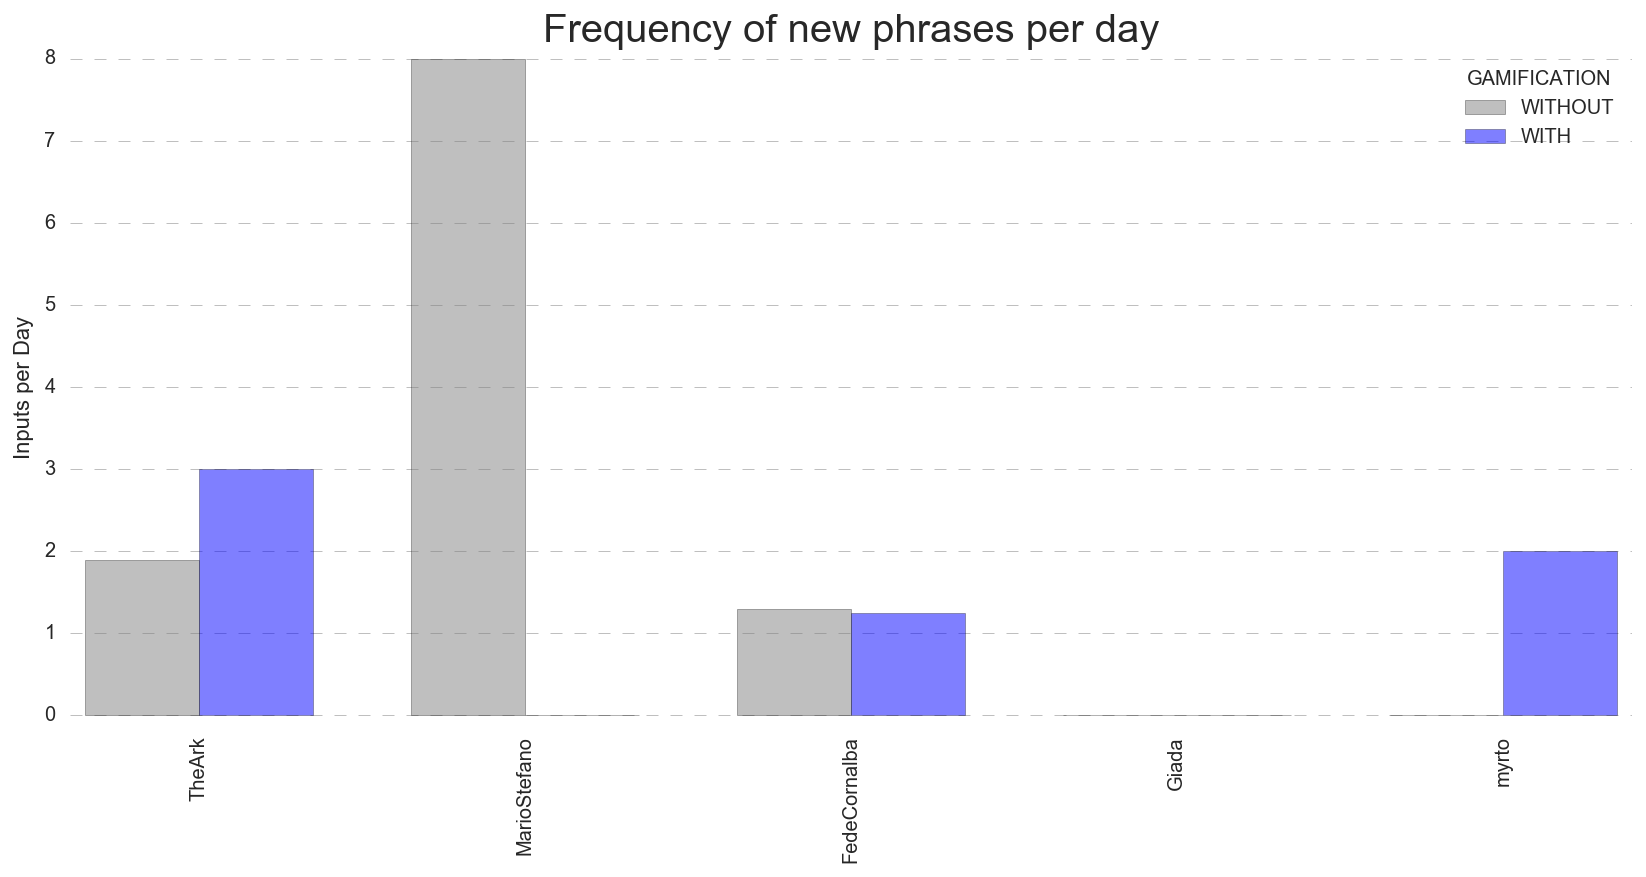

In [49]:
# Use full resolution of retina display
%config InlineBackend.figure_format = 'retina'

# Create a variable for bar-width
bar_width = 0.35

# use seaborn to set our graphing style. The style 'white' creates a white background for our graph
sns.set_style("white") 

# Assign x and y values
x = complete_list
y_without = [avg_stats(i, 'NO', 1)[1] for i in complete_list]
y_with = [avg_stats(i, 'YES', 1)[1] for i in complete_list]

# Give indeces to crimes
x_pos = np.arange(len(x))

# Assign the size of the plot before declaring the plot
plt.figure(figsize=(14, 6))

# Create a series of grey dashed lines across the each
# labled y-value of the graph
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)

# Give the x and y values to the barplot
plt.bar(x_pos, y_without, bar_width , color='grey', alpha=.5, label = 'WITHOUT')
plt.bar(x_pos + bar_width, y_with, bar_width, color='blue', alpha=.5, label = 'WITH')

# Match the indeces with the correct call category and assign them to the x-axis
plt.yticks(np.arange(0,10,1))
plt.xticks(x_pos + bar_width, x,  rotation='vertical')
plt.margins(0.01)

# get rid of borders for our graph using seaborn's despine function
sns.despine(top=1, right=1, left=1, bottom=1)

# Give labels and titles
plt.ylabel("Inputs per Day")
plt.title("Frequency of new phrases per day",fontsize=20)
plt.legend(loc='upper right', title= 'GAMIFICATION')

# Show the barplot
plt.show()

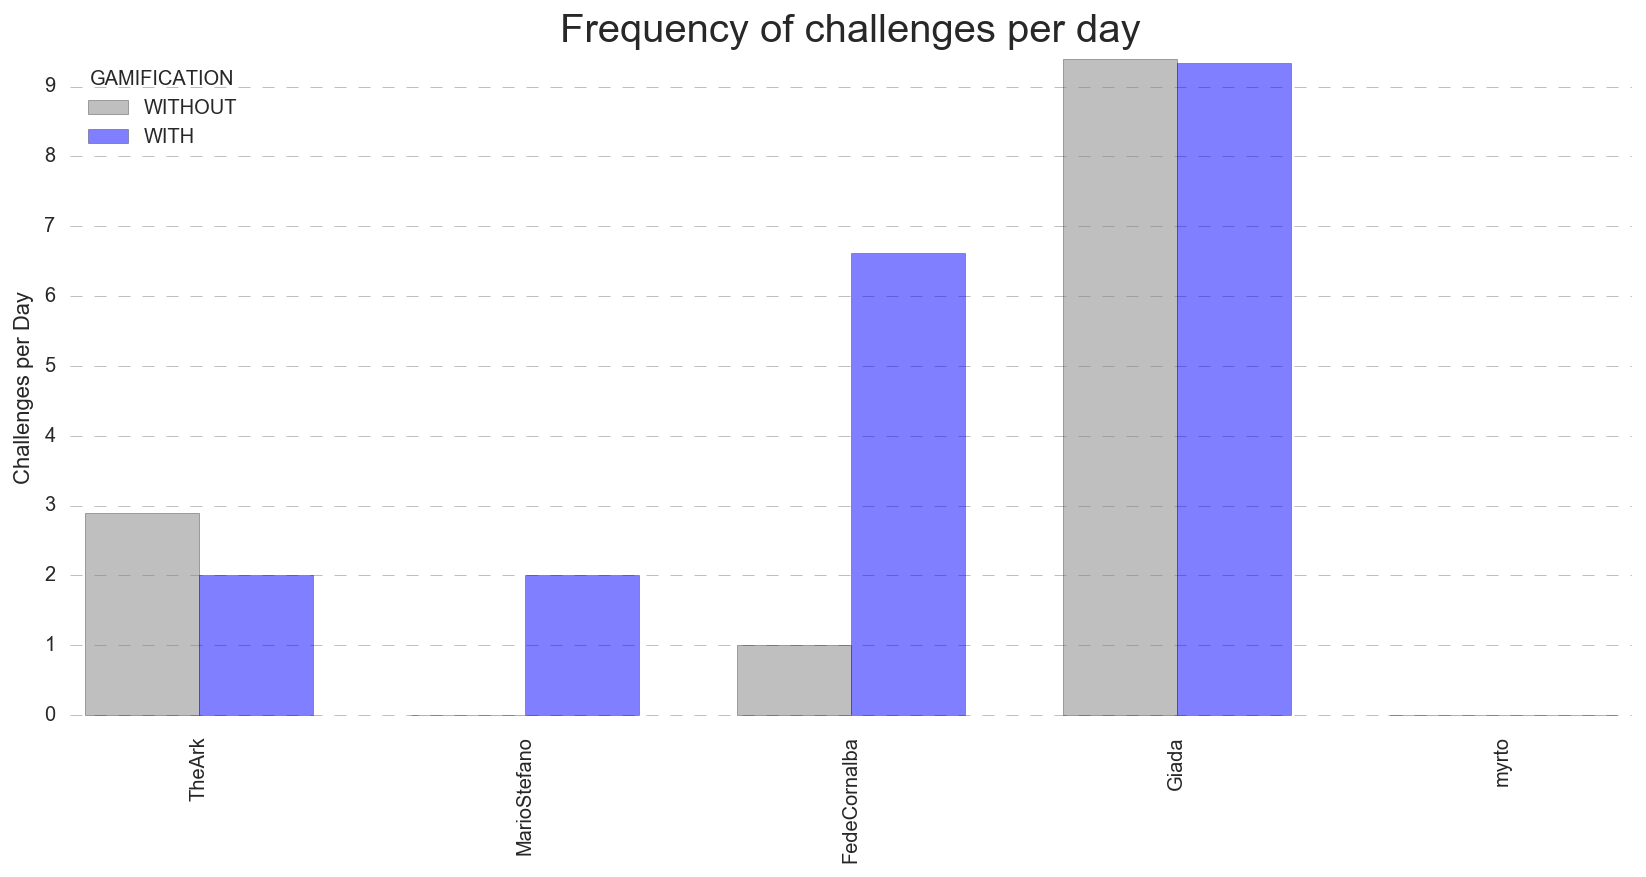

In [50]:
# Use full resolution of retina display
%config InlineBackend.figure_format = 'retina'

# Create a variable for bar-width
bar_width = 0.35

# use seaborn to set our graphing style. The style 'white' creates a white background for our graph
sns.set_style("white") 

# Assign x and y values
x = complete_list
y_without = [avg_stats(i, 'NO', 2)[1] for i in complete_list]
y_with = [avg_stats(i, 'YES', 2)[1] for i in complete_list]

# Give indeces to crimes
x_pos = np.arange(len(x))

# Assign the size of the plot before declaring the plot
plt.figure(figsize=(14, 6))

# Create a series of grey dashed lines across the each
# labled y-value of the graph
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)

# Give the x and y values to the barplot
plt.bar(x_pos, y_without, bar_width , color='grey', alpha=.5, label = 'WITHOUT')
plt.bar(x_pos + bar_width, y_with, bar_width, color='blue', alpha=.5, label = 'WITH')

# Match the indeces with the correct call category and assign them to the x-axis
plt.yticks(np.arange(0,10,1))
plt.xticks(x_pos + bar_width, x,  rotation='vertical')
plt.margins(0.01)

# get rid of borders for our graph using seaborn's despine function
sns.despine(top=1, right=1, left=1, bottom=1)

# Give labels and titles
plt.ylabel("Challenges per Day")
plt.title("Frequency of challenges per day",fontsize=20)
plt.legend(loc='upper left', title= 'GAMIFICATION')

# Show the barplot
plt.show()

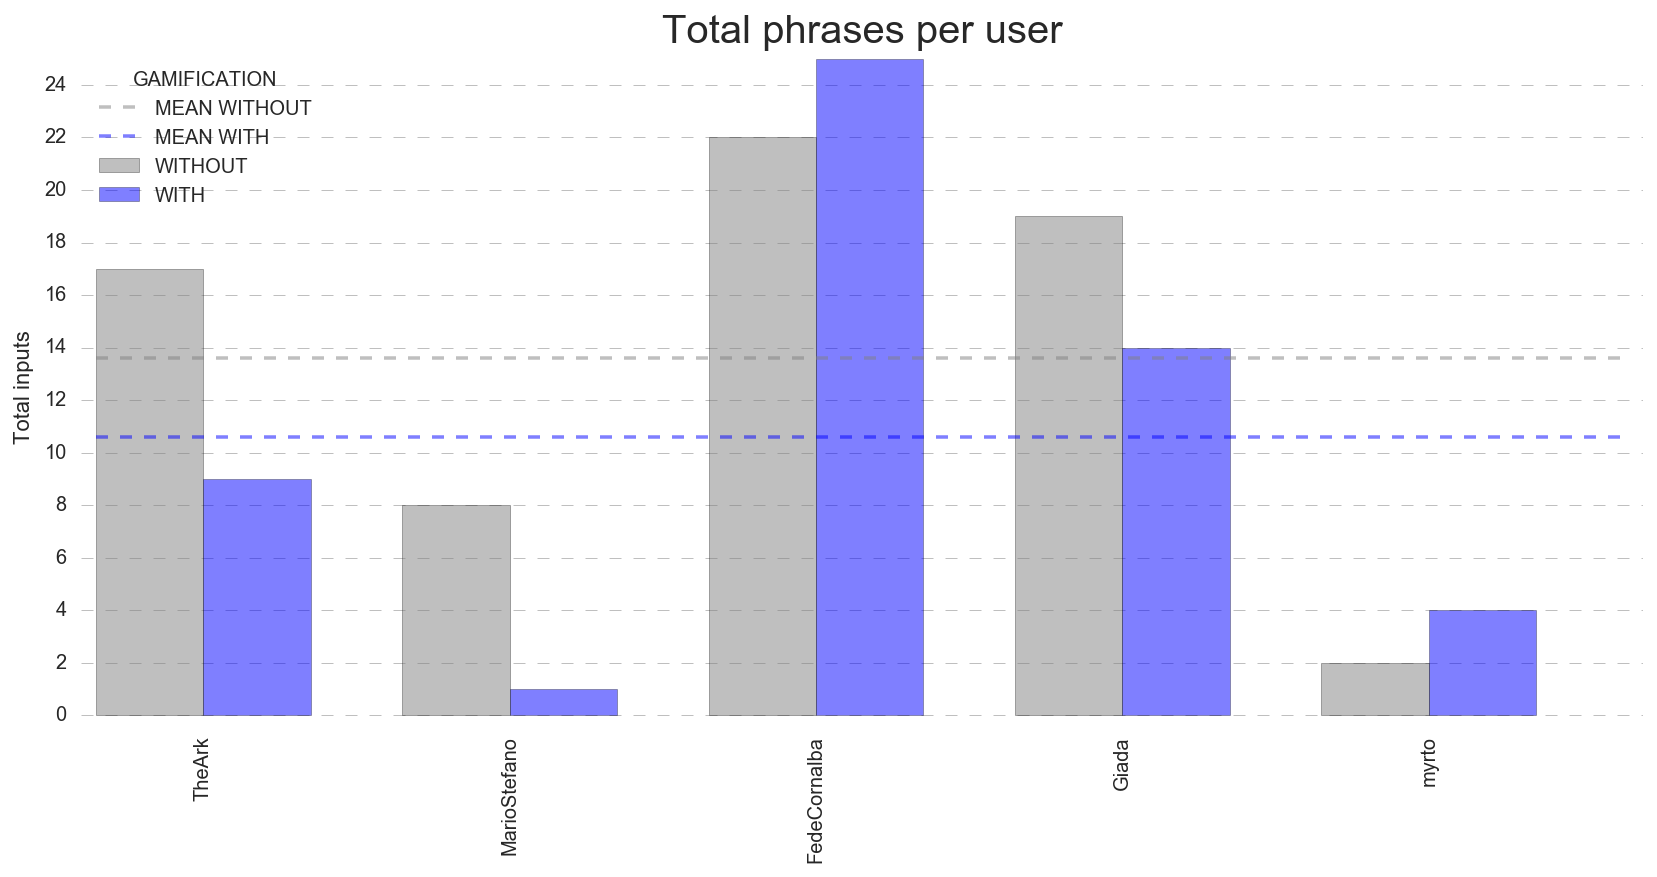

In [71]:
# Use full resolution of retina display
%config InlineBackend.figure_format = 'retina'

# Create a variable for bar-width
bar_width = 0.35

# use seaborn to set our graphing style. The style 'white' creates a white background for our graph
sns.set_style("white") 

# Assign x and y values
x = complete_list
y_without = [len(loadUserInfo(i,'NO')[1]) for i in complete_list]
y_with = [len(loadUserInfo(i,'YES')[1])-len(loadUserInfo(i,'NO')[1]) for i in complete_list]

# Give indeces to crimes
x_pos = np.arange(len(x))

# Assign the size of the plot before declaring the plot
plt.figure(figsize=(14, 6))

# Create a series of grey dashed lines across the each
# labled y-value of the graph
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)

# Give the x and y values to the barplot
plt.bar(x_pos, y_without, bar_width , color='grey', alpha=.5, label = 'WITHOUT')
plt.bar(x_pos + bar_width, y_with, bar_width, color='blue', alpha=.5, label = 'WITH')
plt.plot([i for i in range(len(y_without) + 1)], [np.mean(y_without) for _ in range(len(y_without) + 1)], linestyle='--', color = 'grey', alpha = .5, label = 'MEAN WITHOUT')
plt.plot([i for i in range(len(y_with) + 1)], [np.mean(y_with) for _ in range(len(y_with) + 1)], linestyle='--', color = 'blue', alpha = .5, label = 'MEAN WITH')

# Match the indeces with the correct call category and assign them to the x-axis
plt.yticks(np.arange(0,30,2))
plt.xticks(x_pos + bar_width, x,  rotation='vertical')
plt.margins(0.01)

# get rid of borders for our graph using seaborn's despine function
sns.despine(top=1, right=1, left=1, bottom=1)

# Give labels and titles
plt.ylabel("Total inputs")
plt.title("Total phrases per user",fontsize=20)
plt.legend(loc='upper left', title= 'GAMIFICATION')

# Show the barplot
plt.show()

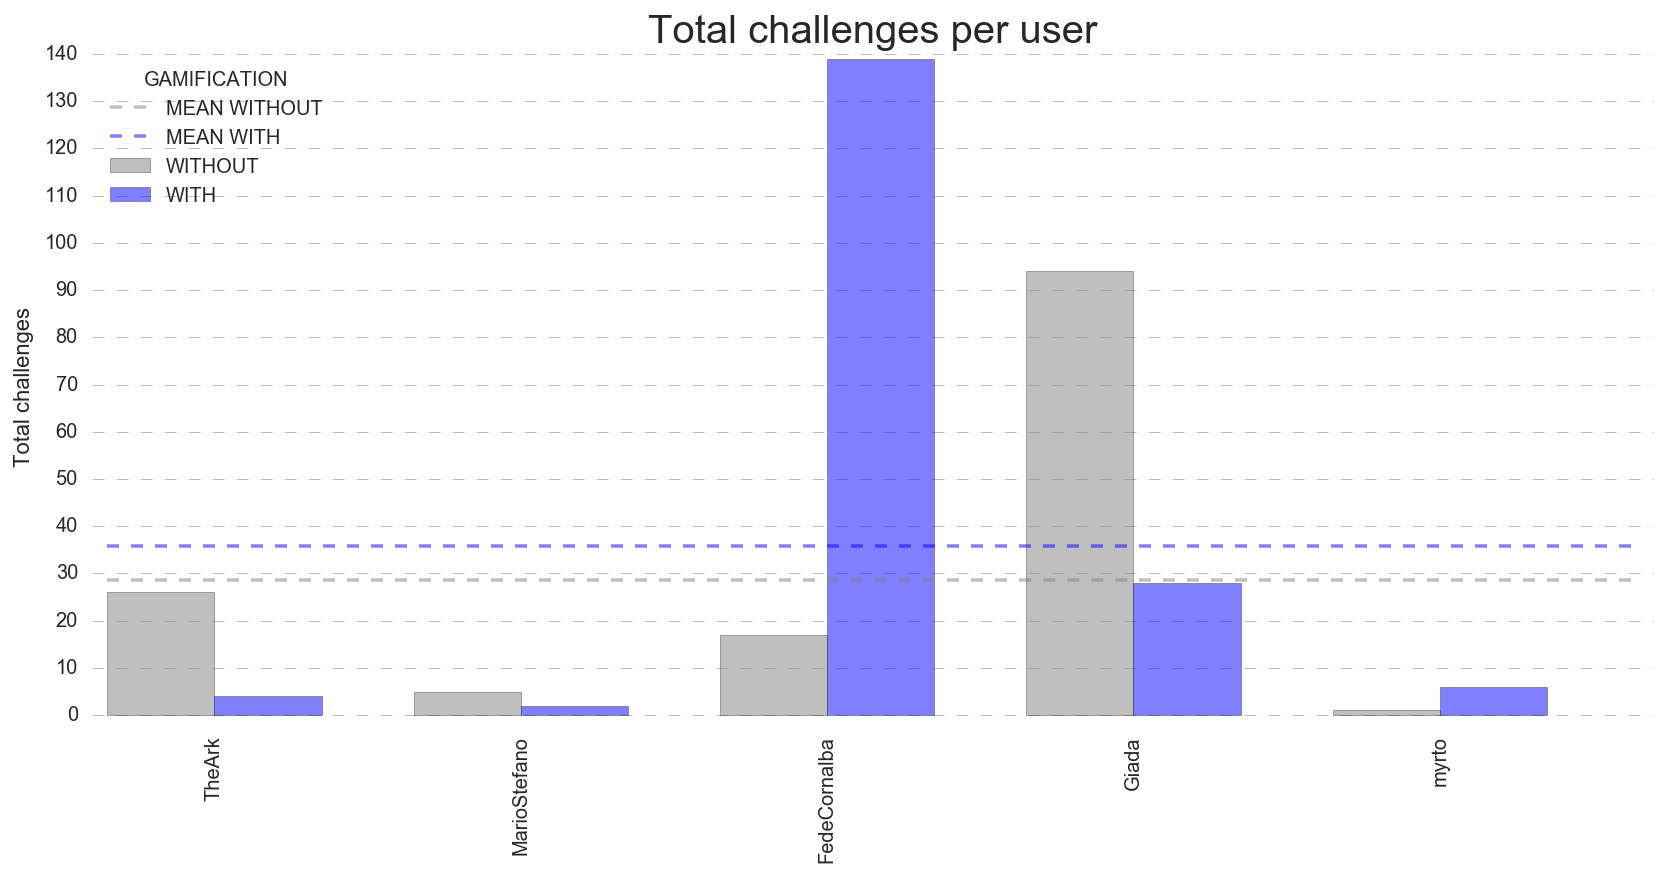

In [73]:
# Use full resolution of retina display
%config InlineBackend.figure_format = 'retina'

# Create a variable for bar-width
bar_width = 0.35

# use seaborn to set our graphing style. The style 'white' creates a white background for our graph
sns.set_style("white") 

# Assign x and y values
x = complete_list
y_without = [len(loadUserInfo(i,'NO')[2]) for i in complete_list]
y_with = [len(loadUserInfo(i,'YES')[2])-len(loadUserInfo(i,'NO')[2]) for i in complete_list]

# Give indeces to crimes
x_pos = np.arange(len(x))

# Assign the size of the plot before declaring the plot
plt.figure(figsize=(14, 6))

# Create a series of grey dashed lines across the each
# labled y-value of the graph
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)

# Give the x and y values to the barplot
plt.bar(x_pos, y_without, bar_width , color='grey', alpha=.5, label = 'WITHOUT')
plt.bar(x_pos + bar_width, y_with, bar_width, color='blue', alpha=.5, label = 'WITH')
plt.plot([i for i in range(len(y_without) + 1)], [np.mean(y_without) for _ in range(len(y_without) + 1)], linestyle='--', color = 'grey', alpha = .5, label = 'MEAN WITHOUT')
plt.plot([i for i in range(len(y_with) + 1)], [np.mean(y_with) for _ in range(len(y_with) + 1)], linestyle='--', color = 'blue', alpha = .5, label = 'MEAN WITH')

# Match the indeces with the correct call category and assign them to the x-axis
plt.yticks(np.arange(0,150,10))
plt.xticks(x_pos + bar_width, x,  rotation='vertical')
plt.margins(0.01)

# get rid of borders for our graph using seaborn's despine function
sns.despine(top=1, right=1, left=1, bottom=1)

# Give labels and titles
plt.ylabel("Total challenges")
plt.title("Total challenges per user",fontsize=20)
plt.legend(loc='upper left', title= 'GAMIFICATION')

# Show the barplot
plt.show()

## Discussion

It is just an initial version of the analysis. I will further investigate and create plots at a later stage but first I need to know if I am in the correct path. Please add any comments for improvemets and later analysis here. As you see the tables are a bit complicated to analyze as we don't have enough data for a summary for all users. Play around by checking all JSON filenames. 